## 從ARIMA整合移動平均自回歸模型，時間序列預測未來1個月Bitcoin價格
#### 從時間序列的過去值及現在值來預測未來值，使用序列的平穩化處理跟STL-decomposition
    （一）根據時間序列的散點圖、自相關函數和偏自相關函數圖以ADF單位根檢驗其方差、趨勢及其季節性變化規律，對序列的平穩性進行識別。一般來講，經濟運行的時間序列都不是平穩序列。

　　（二）對非平穩序列進行平穩化處理。如果數據序列是非平穩的，並存在一定的增長或下降趨勢，則需要對數據進行差分處理，如果數據存在異方差，則需對數據進行技術處理，直到處理後的數據的自相關函數值和偏相關函數值無顯著地異於零。

　　（三）根據時間序列模型的識別規則，建立相應的模型。若平穩序列的偏相關函數是截尾的，而自相關函數是拖尾的，可斷定序列適合AR模型；若平穩序列的偏相關函數是拖尾的，而自相關函數是截尾的，則可斷定序列適合MA模型；若平穩序列的偏相關函數和自相關函數均是拖尾的，則序列適合ARMA模型。

　　（四）進行參數估計，檢驗是否具有統計意義。

　　（五）進行假設檢驗，診斷殘差序列是否為白雜訊。

　　（六）利用已通過檢驗的模型進行預測分析。


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

## 資料檢索
#### 使用Kaggle提供Bitcoin2012-2018每分鐘CSV交易資料集

In [2]:
df = pd.read_csv('C:/Users/youngtec/input/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


## 重新採樣每日、每月、每年、每季資料

In [3]:
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
df.index = df.Timestamp
df = df.resample('D').mean()
df_month = df.resample('M').mean()
df_year = df.resample('A-DEC').mean()
df_Q = df.resample('Q-DEC').mean()

## 顯示Bitcoin的美元走勢

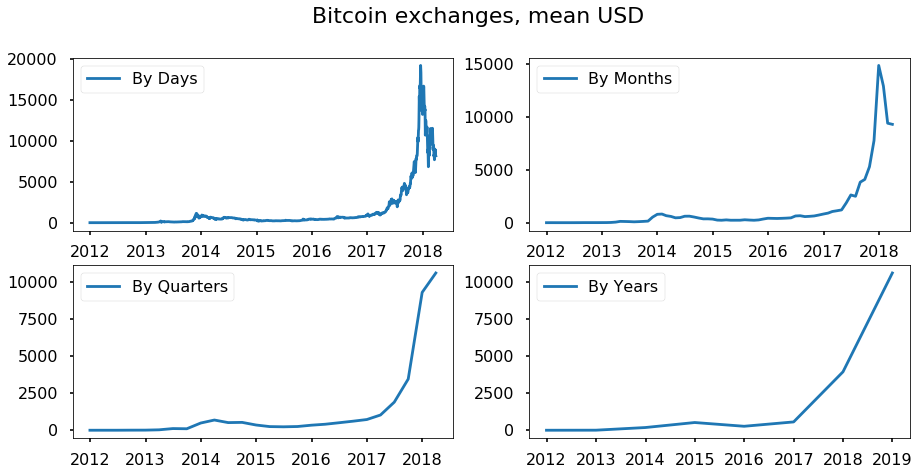

In [4]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

plt.show()

## 使用序列的平穩化處理跟STL-decomposition

Dickey–Fuller test: p=0.998488


<Figure size 1080x504 with 0 Axes>

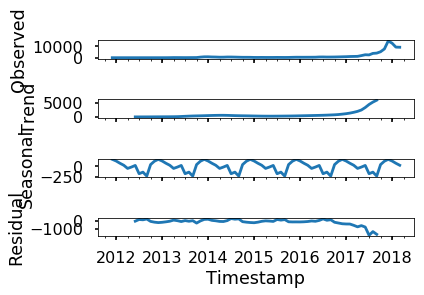

In [5]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

## Box-Cox轉換

In [6]:
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.998488


## Seasonal 季節性差異

In [7]:
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.069401


## Regular 定期性差異

Dickey–Fuller test: p=0.009387


<Figure size 1080x504 with 0 Axes>

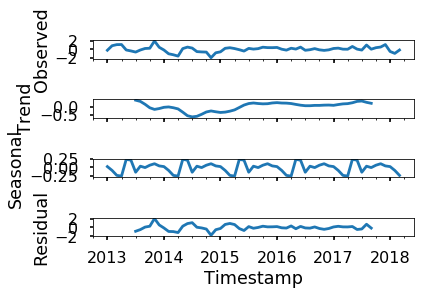

In [8]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

## 模型選擇
#### 透過自相關函數和偏自相關函數建立模型

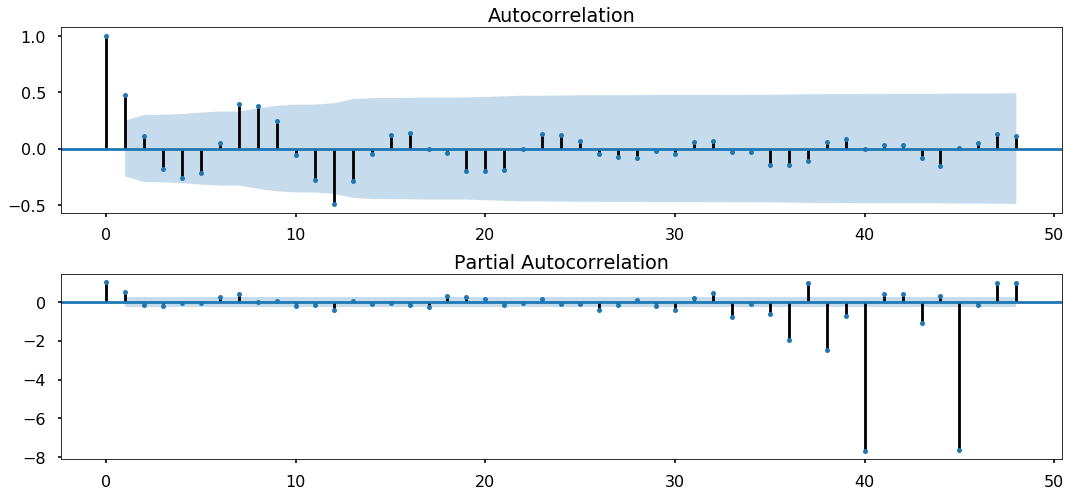

In [9]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [10]:
# 初始化相似參數值
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 2, 1)


In [11]:
# 使用最佳模型
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
43  (2, 2, 0, 1)  83.995929
19  (1, 0, 0, 1)  84.018521
21  (1, 0, 1, 1)  84.274362
45  (2, 2, 1, 1)  84.848972
7   (0, 1, 0, 1)  85.143093
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                   76
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood                 -35.998
Date:                            Thu, 28 Jun 2018   AIC                             83.996
Time:                                    16:37:21   BIC                             96.855
Sample:                                12-31-2011   HQIC                            89.053
                                     - 03-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

In [14]:
##進行假設檢驗，診斷殘差序列分析

Dickey–Fuller test:: p=0.000000


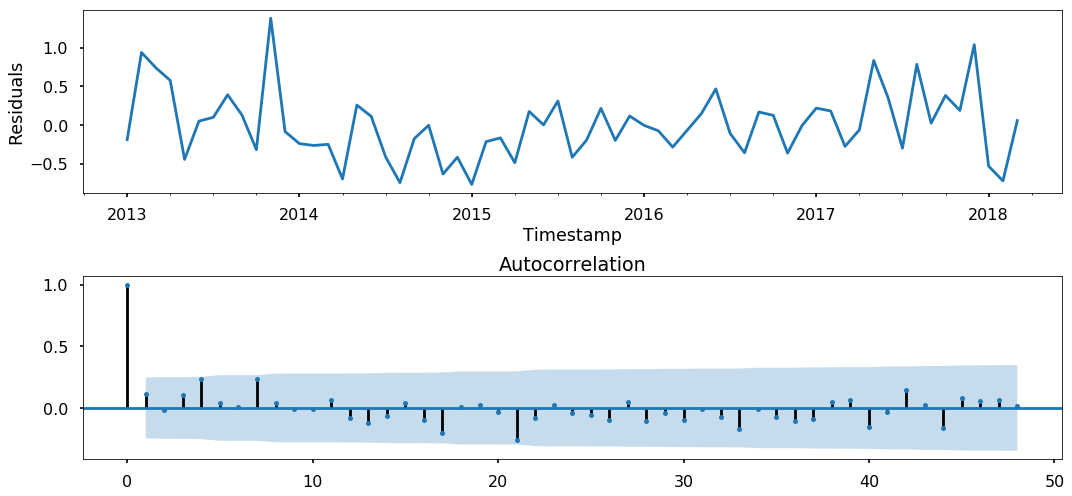

In [15]:
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

## 預測Bitcoin比特幣未來1個月交易價格
#### 透過反轉Box-Cox轉換函數後，預測出價格走勢

In [18]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

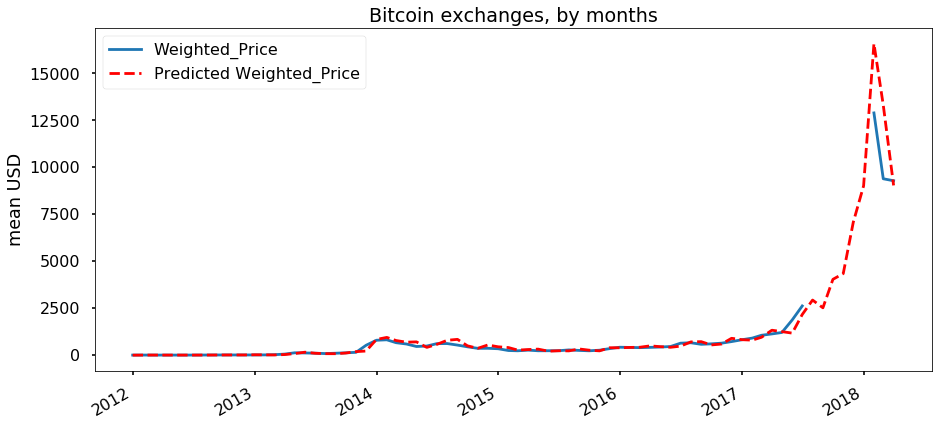

In [19]:
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),datetime(2018, 5, 31),
             datetime(2018, 10, 30)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()